In [1]:
from sklearn.datasets import fetch_mldata
import numpy as np
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST/",one_hot=True)
trX, trY = mnist.train.images, mnist.train.labels
teX, teY = mnist.test.images, mnist.test.labels

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
N = 1000

In [4]:
dummy_X = np.random.rand(N,2)
def f(x):
    return 0.5+np.sin(10*x[0])*.4 < x[1]

dummy_Y = np.array([f(x) for x in dummy_X])

In [5]:
# X - some data in 2dimensional np.array
def plot(model,X,Y,shades=False,**kwargs):
    plt.figure(figsize=(10,5))
    h = 50
    x_min, x_max = 0,1
    y_min, y_max = 0,1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, h),
                         np.linspace(y_min, y_max, h))

    # here "model" is your model's prediction (classification) function
    Z = model(np.c_[xx.ravel(), yy.ravel()]) 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    if 'levels' in kwargs and len(kwargs['levels']) > 2:
        plt.subplot(1, 2, 1)
        plt.contourf(xx, yy, Z, cmap=plt.cm.gist_earth,**kwargs)
        plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
    
    
    plt.subplot(1, 2,2)
    plt.contourf(xx, yy, Z, cmap=plt.cm.gist_earth,**kwargs)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
    #plt.axis('off')

    # Plot also the training points

In [6]:
def optimal(X):
    return np.array([f(x) for x in X])

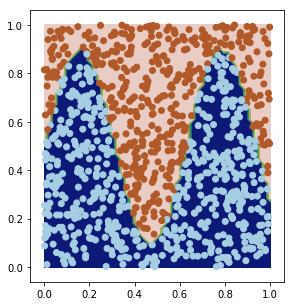

In [7]:
plot(optimal,dummy_X,dummy_Y,shades=True)

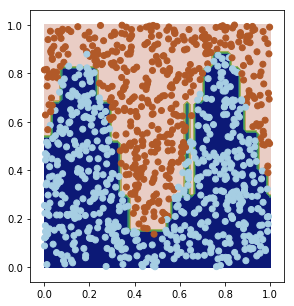

In [8]:
dt = DecisionTreeClassifier()
dt.fit(dummy_X,dummy_Y)
plot(dt.predict,dummy_X,dummy_Y,shades=True)

In [267]:
from keras.models import Sequential
from keras.layers import Dense, Activation
def keras_wrapper(model):
    return lambda x: model.predict(x)[:,1] > .5




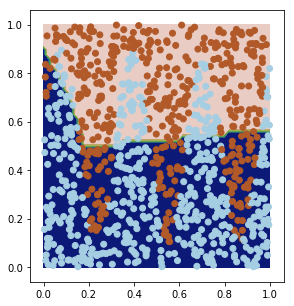

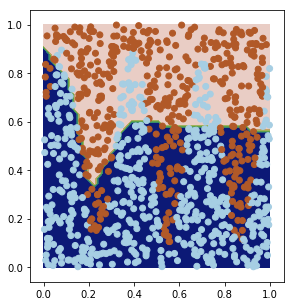

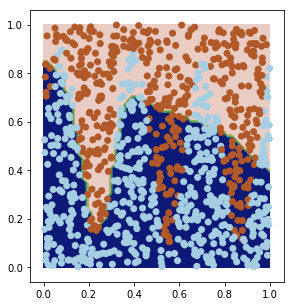

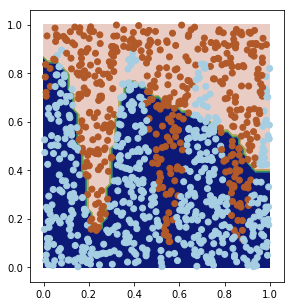

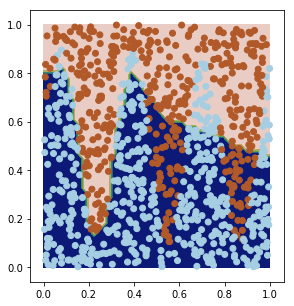

In [405]:
model = Sequential([
    Dense(100,input_shape=(2,)),
    Activation('relu'),
    Dense(2),
    Activation('softmax'),
])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
dummy_Y2 = np.vstack((dummy_Y==0,dummy_Y==1)).T
for i in range(5):
    model.fit(dummy_X, dummy_Y2, nb_epoch=100, batch_size=10,verbose=0)
    plt.figure()
    plot(keras_wrapper(model),dummy_X,dummy_Y,shades=True)
    

In [9]:
import tqdm # Using this for dynamic updates instead of unwieldy print statements
import time # Timing how long it takes an epoch to run


def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

def update_d(prev,new):
    combined = prev.copy()
    combined.update(new)
    return combined 

class FakeTQDM:
    def __init__(self,*args,**kwargs):
        pass
    def set_description(self,*args,**kwargs):
        pass
    def update(self,*args,**kwargs):
        pass
    def __exit__(self,*args,**kwargs):
        pass
    def __enter__(self,*args,**kwargs):
        return self
def train_model(sess,train_X,train_Y, test_X,test_Y,train_operation,accuracy_operation,num_epochs,batch_size,test_size,train_feed=dict(),test_feed=dict(),howOften=100,plot=True,show_ranger=True):
    accuracies = []
    startingTime = time.time()
    
    with (tqdm.tqdm_notebook(total= num_epochs * len(train_X)) if show_ranger else FakeTQDM()) as ranger:
        for epoch in range(num_epochs):
            for start in range(0,len(train_X),batch_size):
                end = start + batch_size
                sess.run(train_operation, \
                     feed_dict = update_d(train_feed,{X: train_X[start:end],Y: train_Y[start:end]}))
                ranger.update(batch_size)
                if (start//batch_size)%howOften == 0: 
                    testSet = np.random.choice(len(test_X),test_size,replace=False)
                    tX,tY = test_X[testSet],test_Y[testSet]
                    accuracies.append(sess.run(accuracy_operation,feed_dict= update_d(test_feed,{X: tX,Y: tY})))
                    ranger.set_description("Test Accuracy: " + str(accuracies[-1]))
                    
            testSet = np.random.choice(len(test_X),test_size,replace=False)
            tX,tY = test_X[testSet],test_Y[testSet]
            accuracies.append(sess.run(accuracy_operation,feed_dict= update_d(test_feed,{X: tX,Y: tY})))
            ranger.set_description("Test Accuracy: " + str(accuracies[-1]))
    
    timeTaken = time.time() - startingTime
    if plot:
        print("Finished training for %d epochs"%num_epochs)
        print("Took %.02f seconds (%.02f s per epoch)"%(timeTaken,timeTaken/num_epochs))
        accuracies.append(sess.run(accuracy_operation,feed_dict= update_d(test_feed,{X: test_X,Y: test_Y})))
        print("Final accuracy was %.04f"%accuracies[-1])
        plt.plot(accuracies)

In [10]:
with FakeTQDM() as ranger:
    print(ranger)

In [11]:
def get_dt_from_model(probability_model):
    y_probs = probability_model(dummy_X)*.7+.5*.3
    sampled_Ys = []
    lengths = []
    for i in range(10):
        sampled_Y = np.random.rand(len(dummy_X)) > y_probs
        dt = DecisionTreeClassifier(min_impurity_split=0.3)
        dt.fit(dummy_X,sampled_Y)
        v = dt.decision_path(dummy_X)
        average_length = v.getnnz()/len(dummy_X)-1
        lengths.append((sampled_Y!=dummy_Y)+average_length)
        sampled_Ys.append(sampled_Y)
    return {'X':np.concatenate([dummy_X]*10),'Y':np.concatenate(sampled_Ys), 'R':np.concatenate(lengths)}


In [12]:
set(l)

NameError: name 'l' is not defined

2.392

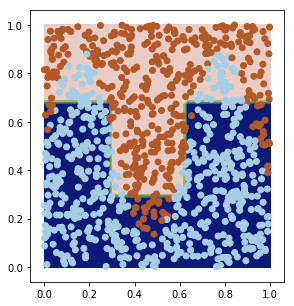

In [13]:
dt = DecisionTreeClassifier(min_impurity_split=0.3)
dt.fit(dummy_X,dummy_Y)
plot(dt.predict,dummy_X,dummy_Y,shades=True)
v = dt.decision_path(dummy_X)
v.getnnz()/len(dummy_X)-1

In [16]:
sess = tf.InteractiveSession()

In [17]:
X = tf.placeholder("float",shape=[None,2])
Y = tf.placeholder("float",shape=[None,2])
avg_height = tf.placeholder("float")
sampled_Y = tf.placeholder("float",shape=[None,2])

initializer = tf.contrib.layers.xavier_initializer()
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.1))

def create_main_NN(inp_X,layer_sizes,op=tf.nn.relu):
    """
    Creates a neural network, without an activation on the last layer
    """
    current_len = layer_sizes[0]
    for hidden_size in layer_sizes[1:-1]:
        new_weight_layer = init_weights((current_len,hidden_size))
        new_bias_layer = init_weights((hidden_size,))
        inp_X = tf.nn.relu(tf.matmul(inp_X,new_weight_layer)+new_bias_layer)
        current_len = hidden_size
    last_weight_layer = init_weights((current_len,layer_sizes[-1]))
    return tf.matmul(inp_X,last_weight_layer)

model = create_main_NN(X,(2,100,100,2))
probabilities = tf.nn.softmax(model)
log_probabilities = tf.nn.log_softmax(model)
reward_weighted_lp = tf.reduce_mean(tf.reduce_sum(log_probabilities*sampled_Y,axis=1)*avg_height)
sample_cost = tf.reduce_sum((probabilities-Y)**2,axis=1)#tf.nn.softmax_cross_entropy_with_logits(logits=model,labels=Y)
total_cost = tf.reduce_sum(sample_cost)
train_operation = tf.train.AdamOptimizer().minimize(total_cost)
pg_operation = tf.train.AdamOptimizer().minimize((reward_weighted_lp))

predict_operation = tf.argmax(model, 1)
accuracy_operation = tf.reduce_mean(
                        tf.cast(tf.equal(predict_operation,tf.argmax(Y,1)),tf.float32)
                        )

In [19]:
def tf_wrapper(logit_operation,X_var):
    return lambda X: sess.run(logit_operation,feed_dict={X_var:X})[:,1] > .5
def tf_prob(logit_operation,X_var):
    return lambda X: sess.run(logit_operation,feed_dict={X_var:X})[:,1]

Instructions for updating:
Use `tf.global_variables_initializer` instead.

Finished training for 1000 epochs
Took 12.18 seconds (0.01 s per epoch)
Final accuracy was 0.9980


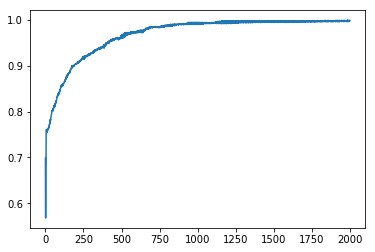

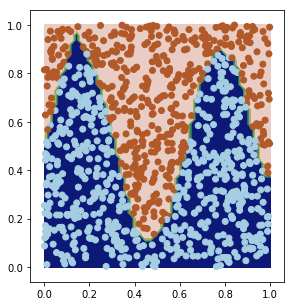

In [29]:
dummy_Y2 = np.vstack((dummy_Y==0,dummy_Y==1)).T.astype(float)
tf.initialize_all_variables().run()

train_model(sess,dummy_X,dummy_Y2,dummy_X,dummy_Y2,train_operation,accuracy_operation,1000,100,len(dummy_X))
plot(tf_wrapper(probabilities,X),dummy_X,dummy_Y,shades=True)

In [22]:
def get_reward_from_model(probability_model):
    y_probs = probability_model(dummy_X)*.7+.5*.3
    #print(y_probs)
    sampled_Ys = []
    lengths = []
    for i in range(10):
        sampled_Y = np.random.rand(len(dummy_X)) < y_probs
        dt = DecisionTreeClassifier(min_impurity_split=0.3)
        dt.fit(dummy_X,sampled_Y)
        v = dt.decision_path(dummy_X)
        average_length = v.getnnz()/len(dummy_X)-1
        lengths.append(20*(sampled_Y!=dummy_Y)+average_length)
        sampled_Ys.append(sampled_Y)
    return {'X':np.concatenate([dummy_X]*10),'Y':np.concatenate(sampled_Ys), 'R':np.concatenate(lengths)}


In [24]:
def average_height():
    dt = DecisionTreeClassifier()
    new_ys = tf_wrapper(probabilities,X)(dummy_X)
    dt.fit(dummy_X,new_ys)
    plot(dt.predict,dummy_X,new_ys,shades=True)
    v = dt.decision_path(dummy_X)
    return v.getnnz()/len(dummy_X)-1

In [501]:
values['R'],values['Y']

(array([ 20.,  20.,   0., ...,   0.,   0.,  20.]), array([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]]))

Instructions for updating:
Use `tf.global_variables_initializer` instead.

Finished training for 100 epochs
Took 1.16 seconds (0.01 s per epoch)
Final accuracy was 0.9010
4.402 0.901 -14.6907

Finished training for 100 epochs
Took 1.35 seconds (0.01 s per epoch)
Final accuracy was 0.9780
4.549 0.978 -20.5932

Finished training for 100 epochs
Took 1.21 seconds (0.01 s per epoch)
Final accuracy was 0.9870
4.99 0.987 -30.3545

Finished training for 100 epochs
Took 1.25 seconds (0.01 s per epoch)
Final accuracy was 0.9920
4.953 0.992 -38.2145

Finished training for 100 epochs
Took 1.33 seconds (0.01 s per epoch)
Final accuracy was 0.9960
4.923 0.996 -49.4135

Finished training for 100 epochs
Took 1.26 seconds (0.01 s per epoch)
Final accuracy was 0.9950
4.922 0.995 -60.1517

Finished training for 100 epochs
Took 1.27 seconds (0.01 s per epoch)
Final accuracy was 0.9780
4.648 0.978 -80.2976

Finished training for 100 epochs
Took 1.30 seconds (0.01 s per epoch)
Final accuracy was 0.9800
4.90

KeyboardInterrupt: 

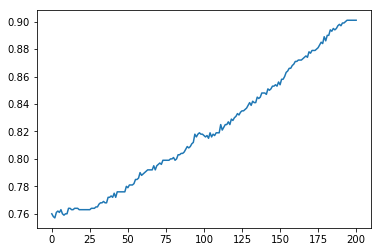

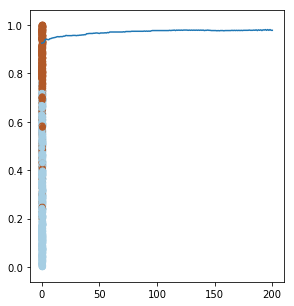

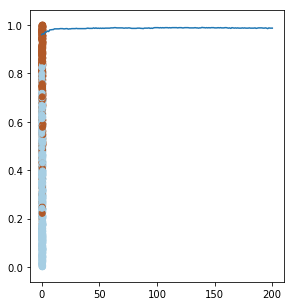

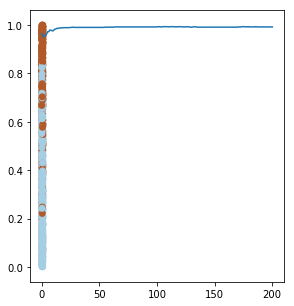

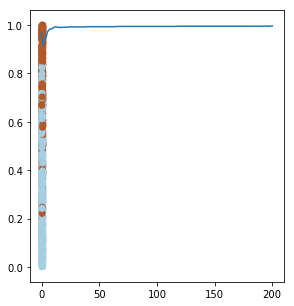

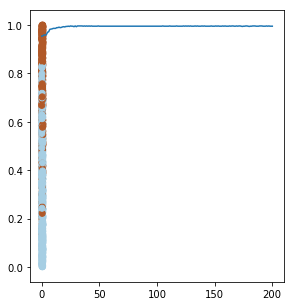

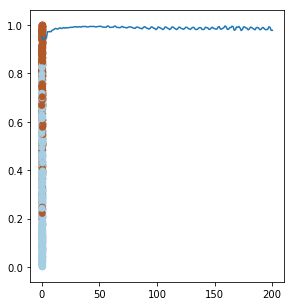

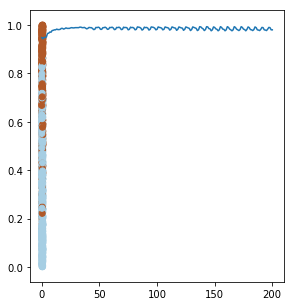

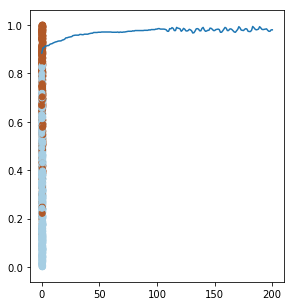

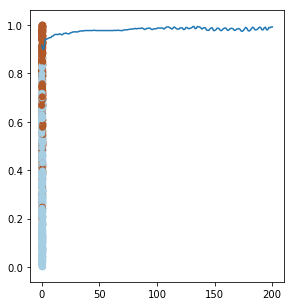

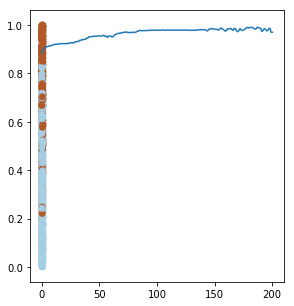

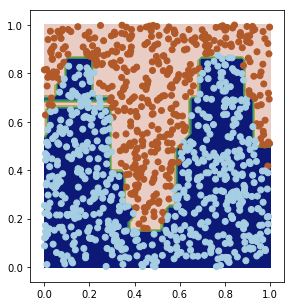

In [33]:
def to_weird(Y):
    return np.vstack((Y==0,Y==1)).T.astype(float)
tf.initialize_all_variables().run()

for _ in range(20):
    for i in range(30):
        train_model(sess,dummy_X,dummy_Y2,dummy_X,dummy_Y2,train_operation,accuracy_operation,2,len(dummy_X),len(dummy_X),plot=False,show_ranger=False)
        values = get_reward_from_model(tf_prob(probabilities,X))
        values['Y'] = to_weird(values['Y'])
        for _ in range(2):
            sess.run(pg_operation,feed_dict={X:values['X'],sampled_Y:values['Y'],avg_height:values['R']})
    train_model(sess,dummy_X,dummy_Y2,dummy_X,dummy_Y2,train_operation,accuracy_operation,100,100,len(dummy_X))
    print(average_height(),sess.run(accuracy_operation,feed_dict={X:dummy_X,Y:dummy_Y2}),sess.run(reward_weighted_lp,feed_dict={X:values['X'],sampled_Y:values['Y'],avg_height:values['R']}))

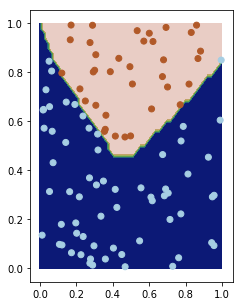

In [292]:
plot(tf_wrapper(probabilities,X),dummy_X,dummy_Y,shades=True)

# MNIST

In [167]:
from sklearn.preprocessing import OneHotEncoder

In [194]:
dt = DecisionTreeClassifier()
dt.fit(trX,trY2)
mnist_ohc = OneHotEncoder(10)
dt_mnist_predictions = mnist_ohc.fit_transform(dt.predict(trX).reshape(-1,1)).toarray()

In [187]:
dt_mnist_predictions.shape

(55000, 10)

In [47]:
X = tf.placeholder("float",shape=[None,784])
Y = tf.placeholder("float",shape=[None,10])
avg_height = tf.placeholder("float")
sampled_Y = tf.placeholder("float",shape=[None,10])

initializer = tf.contrib.layers.xavier_initializer()
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.1))

def create_main_NN(inp_X,layer_sizes,op=tf.nn.relu):
    """
    Creates a neural network, without an activation on the last layer
    """
    current_len = layer_sizes[0]
    for hidden_size in layer_sizes[1:-1]:
        new_weight_layer = init_weights((current_len,hidden_size))
        new_bias_layer = init_weights((hidden_size,))
        inp_X = tf.nn.relu(tf.matmul(inp_X,new_weight_layer)+new_bias_layer)
        current_len = hidden_size
    last_weight_layer = init_weights((current_len,layer_sizes[-1]))
    return tf.matmul(inp_X,last_weight_layer)

model = create_main_NN(X,(784,500,100,10))
probabilities = tf.nn.softmax(model)
log_probabilities = tf.nn.log_softmax(model)
reward_weighted_lp = tf.reduce_mean(tf.reduce_sum(log_probabilities*sampled_Y,axis=1)*avg_height)
sample_cost = tf.nn.softmax_cross_entropy_with_logits(logits=model,labels=Y)
total_cost = tf.reduce_sum(sample_cost)
train_operation = tf.train.AdamOptimizer().minimize(total_cost)
pg_operation = tf.train.AdamOptimizer().minimize((reward_weighted_lp))

predict_operation = tf.argmax(model, 1)
accuracy_operation = tf.reduce_mean(
                        tf.cast(tf.equal(predict_operation,tf.argmax(Y,1)),tf.float32)
                        )

In [191]:
def tf_wrapper(logit_operation,X_var):
    return lambda X: np.argmax(sess.run(logit_operation,feed_dict={X_var:X}),axis=1)
def tf_prob(logit_operation,X_var):
    return lambda X: sess.run(logit_operation,feed_dict={X_var:X})

In [56]:
def mnist_average_height():
    dt = DecisionTreeClassifier(min_impurity_split=0.1)
    new_ys = tf_wrapper(probabilities,X)(trX)
    dt.fit(trX,new_ys)
    v = dt.decision_path(trX)
    return v.getnnz()/len(trX)-1

Instructions for updating:
Use `tf.global_variables_initializer` instead.

Finished training for 10 epochs
Took 12.06 seconds (1.21 s per epoch)
Final accuracy was 0.9727


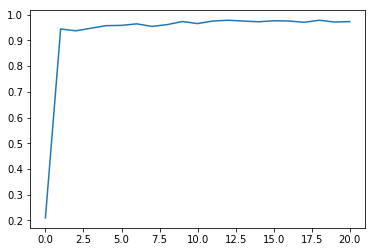

In [245]:
tf.initialize_all_variables().run()

train_model(sess,trX,trY,teX,teY,train_operation,accuracy_operation,10,1000,1000)

Instructions for updating:
Use `tf.global_variables_initializer` instead.

Finished training for 1 epochs
Took 1.34 seconds (1.34 s per epoch)
Final accuracy was 0.9315
0.8602 9.620418181818183
Finished training for 10 epochs
Took 11.81 seconds (1.18 s per epoch)
Final accuracy was 0.9214
Finished training for 1 epochs
Took 1.16 seconds (1.16 s per epoch)
Final accuracy was 0.9582
0.8755 9.6886
Finished training for 10 epochs
Took 11.85 seconds (1.19 s per epoch)
Final accuracy was 0.9416
Finished training for 1 epochs
Took 1.19 seconds (1.19 s per epoch)
Final accuracy was 0.9672
0.8732 9.6636
Finished training for 10 epochs
Took 11.78 seconds (1.18 s per epoch)
Final accuracy was 0.9428
Finished training for 1 epochs
Took 1.18 seconds (1.18 s per epoch)
Final accuracy was 0.9697
0.8745 9.666018181818181
Finished training for 10 epochs
Took 11.77 seconds (1.18 s per epoch)
Final accuracy was 0.9520
Finished training for 1 epochs
Took 1.17 seconds (1.17 s per epoch)
Final accuracy was 

KeyboardInterrupt: 

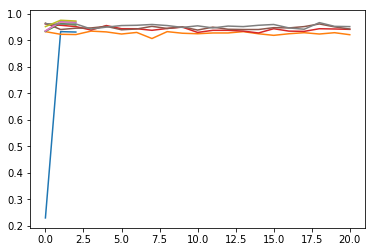

In [256]:
tf.initialize_all_variables().run()
train_model(sess,trX,trY,teX,teY,train_operation,accuracy_operation,1,1000,1000)
for i in range(10):
    func = tf_prob(probabilities,X)
    dt = DecisionTreeClassifier(min_impurity_split=.1)
    dt.fit(trX,func(trX).argmax(1))
    v = dt.decision_path(trX)
    
    mnist_ohc = OneHotEncoder(10)
    dt_mnist_predictions = mnist_ohc.fit_transform(dt.predict(trX).reshape(-1,1)).toarray()
    print(dt.score(teX,teY2),v.getnnz()/len(trX)-1)
    train_model(sess,trX,dt_mnist_predictions,teX,teY,train_operation,accuracy_operation,10,1000,1000,show_ranger=False)
    train_model(sess,trX,trY,teX,teY,train_operation,accuracy_operation,1,1000,1000,show_ranger=False)


In [198]:
mnist_average_height()

9.852854545454546

In [243]:
def get_reward_from_model(probability_model):
    N_samples = 100
    N_points = 50
    starting_point = 0#np.random.choice(50000)
    data_source = trX[starting_point:starting_point+N_points]
    true_ys = trY2[starting_point:starting_point+N_points]
    
    y_probs = probability_model(data_source)*.7+.1*.3
    #print(y_probs)
    sampled_Ys = np.array([(np.random.multinomial(1,p,size=N_samples)==1).argmax(1) for p in y_probs]).T
    lengths = []
    for i in range(N_samples):
        sampled_Y = sampled_Ys[i]
        dt = DecisionTreeClassifier(min_impurity_split=0.1)
        dt.fit(data_source,sampled_Y)
        v = dt.decision_path(data_source)
        average_length = v.getnnz()/len(data_source)-1
        #print(average_length)
        lengths.append((true_ys!=sampled_Y)*10+average_length)
    return {'X':np.concatenate([data_source]*N_samples),'Y':sampled_Ys.flatten(), 'R':np.concatenate(lengths)}


(10, 300)


(array([ 300.,  300.,  600.,  600.,    0.,  300.,    0.,  600.,    0.,  300.]),
 array([ 6.71666667,  6.869     ,  7.02133333,  7.17366667,  7.326     ,
         7.47833333,  7.63066667,  7.783     ,  7.93533333,  8.08766667,
         8.24      ]),
 <a list of 10 Patch objects>)

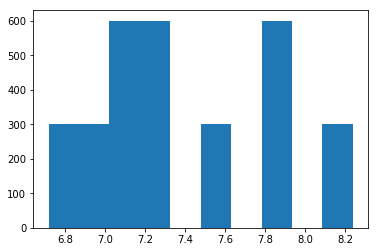

In [225]:
plt.hist(get_reward_from_model(tf_prob(probabilities,X))['R'])

Instructions for updating:
Use `tf.global_variables_initializer` instead.

Finished training for 5 epochs
Took 6.04 seconds (1.21 s per epoch)
Final accuracy was 0.9702
7.9466
8.2796
10.7714
13.389
13.1578
13.256
0.0 0.1009 -5586.17
13.1184
13.1396
13.0548
12.9348
13.183
13.3658
0.0 0.1009 -80595.2
13.2014
13.0018
13.3108
13.3412
12.9154
13.1864
0.0 0.1009 -411696.0
13.208
13.2376
13.0666
12.9314
12.9312
13.0436
0.0 0.1009 -1.13867e+06
12.9648
13.0758
13.3538
13.1012
13.0218
13.1918
0.0 0.1009 -2.64722e+06
13.189
13.272
13.2112
13.0244
13.2826
13.3218
0.0 0.1009 -4.8678e+06
13.1846
12.7932
13.1458
13.0372
13.0896
13.2374
0.0 0.1009 -7.92915e+06
13.1242
13.0658
13.1606
13.434
13.063
13.2354
0.0 0.1009 -1.2055e+07
13.1128
13.1864
13.125
13.2702
13.141
13.1186
0.0 0.1009 -1.82225e+07
12.9374
13.2264
13.342
13.0752
13.2594
13.1886
0.0 0.1009 -2.52781e+07
13.0528
13.1366
13.147
13.1644
12.991
13.1842
0.0 0.1009 -3.32853e+07
13.2184
12.9616
13.089
13.16
13.1052
13.2762
0.0 0.1009 -4.37865e+0

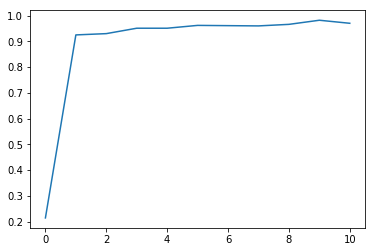

In [244]:
def to_weird(Y):
    return np.vstack((Y==0,Y==1)).T.astype(float)
tf.initialize_all_variables().run()
train_model(sess,trX,trY,teX,teY,train_operation,accuracy_operation,5,1000,1000)

for _ in range(20):
    for i in range(5):
        #train_model(sess,trX,trY,teX,teY,train_operation,accuracy_operation,1,10000,1000,show_ranger=False,plot=False)
        values = get_reward_from_model(tf_prob(probabilities,X))
        print(np.mean(values['R']))
        for _ in range(5):
            values = get_reward_from_model(tf_prob(probabilities,X))
            values['Y'] = mnist_ohc.transform(values['Y'].reshape(-1,1)).toarray()
            sess.run(pg_operation,feed_dict={X:values['X'],sampled_Y:values['Y'],avg_height:values['R']})
            sess.run(pg_operation,feed_dict={X:values['X'],sampled_Y:values['Y'],avg_height:values['R']})

    print(np.mean(values['R']))
    print(mnist_average_height(),sess.run(accuracy_operation,feed_dict={X:teX,Y:teY}),sess.run(reward_weighted_lp,feed_dict={X:values['X'],sampled_Y:values['Y'],avg_height:values['R']}))

In [92]:
%timeit result = (np.random.multinomial(1,p,size=10)==1).argmax(1)

7.15 µs ± 293 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [134]:
(np.random.multinomial(1,p,size=10)==1).argmax(1)

array([6, 6, 6, 8, 1, 6, 5, 8, 9, 4])

In [97]:
result

array([6, 6, 8, 5, 7, 2, 8, 8, 2, 6])